<a href="https://colab.research.google.com/github/bdbejarc/Instrumentos-Opticos/blob/main/Codigo_Entrega_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importar librerías

import pandas as pd
import matplotlib as mlt
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
# Coordenadas de mundo
nm = 1e-9
um = 1e-6
mm = 1e-3
cm = 1e-2

# Longitud de onda
w_length = 650*nm


# # Solo por operación definimos N y M de una imagen 2048 x 2048
# N = 2048 # coordenada X
# M = 2048 # coordenada Y


# Diferenciales, como N y M pendientes por definir para una imagen
dx = dy = 1*um # los diferenciales (tamaño de pixel)

In [7]:
# Función para graficar complejos
def fun_ploteo_complejo(mat, indicador, escala):
    '''
    mat  es una matriz compleja a plotear
    indicador = I para intensidad, A para amplitud, P para fase
    escala = 1 para nada, 0 para logarítmica
    '''
    if(indicador =="I"):
        mat = np.abs(mat)**2
    elif(indicador == "A"):
        mat = np.abs(mat)
    elif(indicador == "P"):
        mat = np.angle(mat)

    if (escala == 1):
        plt.figure()
        plt.imshow(mat)
        plt.colorbar()
        plt.show()
    else:    
        plt.figure()
        plt.imshow( np.log( mat + 0.0001))
        plt.colorbar()
        plt.show()


In [10]:
pera_img = cv2.imread('pera.png', 0)              # Lecutra del .csv como un objeto np.array
print(np.shape(pera_img) )

(32, 32)


In [96]:
gafas_img = cv2.imread('gafas.png', 0)              # Lecutra del .csv como un objeto np.array
print(np.shape(gafas_img) )

(225, 225)


512


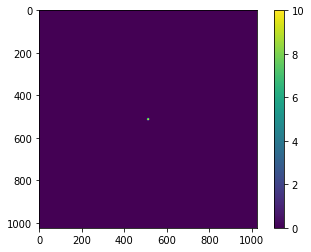

In [93]:
#Abertura circular

mask = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(mask)
coord = int(coord_prev[0]/2)
print (coord)
cv2.circle(mask, (coord, coord), 5, 10, -1)
plt.imshow(mask)
plt.colorbar()
plt.show()

In [74]:
def fun_prop_Fresnel(campo, w_length, z, L_x, L_y, dx, dy, fft = True ):
    ''' 
    
    '''
    # Vector de onda
    k_vect = 2*np.pi/w_length

    # Número de muestras
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)

    # delta espacio del plano z=0, satisfaciendo el requerimiento para el kernel de DFT
    dx_0 = (w_length * z)/(dx * N_x)
    dy_0 = (w_length * z)/(dy * N_y)

    # 2. Preparar U'
    # Preparar U', inicialmente una matriz de ceros
    U_prima = np.zeros(np.shape(campo), dtype = np.complex128)


    #  Este bloque de código es equivalente al anterior, pero con la diferencia que se reemplazaron los valores de dx_0 y dy_0
    # para evitar divisiones por cero cuando z=0
    for n_0 in np.arange(N_x):
        for m_0 in np.arange(N_y):
            U_prima[n_0,m_0] = campo[n_0, m_0] * np.exp( (1j*k_vect/(2*z) ) * ( (n_0*dx_0 )**2 + (m_0*dy_0 )**2) )


     # 3. DFT// de U' para obtener U'' en una pisición z
    if fft == False:
          U_2prima = fun_DFT(U_prima, L_x, L_y, dx, dy)
    else:
          U_2prima = np.fft.fftshift(np.fft.fftn(U_prima))


    # 4. Escalar U
    # Inicialmente U como una matriz de ceros
    U_z = np.zeros(np.shape(campo), dtype = np.complex128)

    # Escalar
    for n in np.arange(N_x):
        for m in np.arange(N_y):
            U_z[n,m] = U_2prima[n,m] * np.exp(1j*k_vect*z)/(1j*w_length*z)  * np.exp( k_vect*1j/(2*z) * ( (n*dx)**2 +(m*dy)**2 ) ) 
    
    return U_z


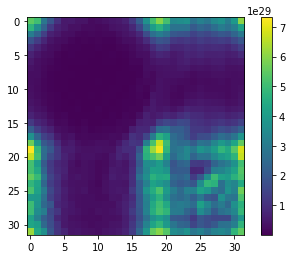

In [92]:
propagado = fun_prop_Fresnel(pera_img, w_length, 30*um, 32*um,32*um,1*um,1*um, True)
fun_ploteo_complejo(propagado, "I", 1)


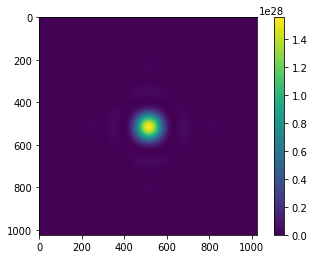

In [94]:
propagado = fun_prop_Fresnel(mask, w_length, 10*um, 1024*um,1024*um,1*um,1*um, True)
fun_ploteo_complejo(propagado, "I", 1)

In [98]:
def Fresnel (campo, w_length, z, dx, dy):
    # Vector de onda
    k_vect = 2*np.pi/w_length

    # Número de muestras
    #N_x = int(L_x/dx)
    #N_y = int(L_y/dy)

    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # delta espacio del plano z=0, satisfaciendo el requerimiento para el kernel de DFT
    dx_0 = X * (w_length * z)/(dx * N)
    dy_0 = Y * (w_length * z)/(dy * M) 

    C1 = np.exp((1j*k_vect/2*z) * ( dx_0**2 + dy_0**2))
    C2 = np.exp((1j*k_vect/z) * (N * dx_0 + M * dy_0))

    # 2. Preparar U'
    U_p = campo * C1

    # 3. DFT// de U' para obtener U'' en una pisición z
    U_2p = np.fft.fftshift(np.fft.fftn(U_p))

    
    # 4. Escalar U
    prop = U_2p * C2



    return prop




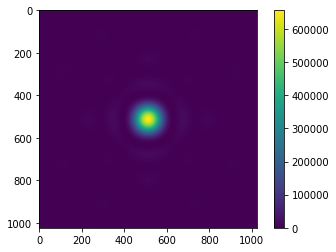

In [95]:
propa = Fresnel(mask, w_length, 5*um,1*um,1*um)
fun_ploteo_complejo(propa, "I", 1)

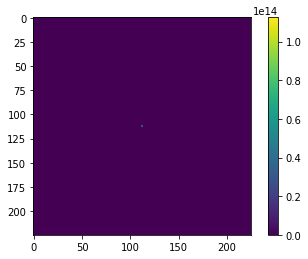

In [99]:
propag = Fresnel(gafas_img, w_length, 5*um,1*um,1*um)
fun_ploteo_complejo(propag, "I", 1)